In [2]:
# Autoreload
%load_ext autoreload
%autoreload 2

In [2]:
# Imports
import numpy as np
import pandas as pd
import numpy as np
import time
import string
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop
import tensorflow as tf
import sys
sys.path.append('../')
from brain2brain import utils
from brain2brain import generators
%matplotlib inline

# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

In [4]:
# utils.get_file_paths_from_root()
# 625
# 717
# 676

In [5]:
# Read saved paths for training.
saved_paths = utils.get_file_paths("../brain2brain/train_files_625.txt")

In [7]:
# Split the train files into a training and validation set.
train, test = utils.split_file_paths(saved_paths, 0.8)

In [8]:
# Print the number of samples.
print(utils.get_total_sample_count(train, lookback=512 * 5, length = 1, delay = 512 * 0))

9471


In [9]:
# Test Generator.

test_generator = generators.FGenerator(file_paths = train, lookback=512 * 5, length = 1, delay = 512 * 0,
                                       batch_size = 32, sample_period = 512 / 64, num_electrodes = 98, shuffle = True)

In [10]:
len(test_generator)

295

In [11]:
X, y = test_generator[0]

In [12]:
X.shape

(32, 320, 98)

In [13]:
y.shape

(32, 1, 98)

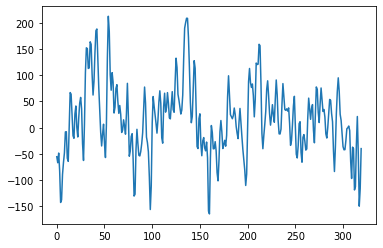

In [14]:
# Plot one electrode
plt.plot(range(X.shape[1]), X[0,:,1])

In [ ]:
electrode_count = len()

In [16]:
# Computing the common-sense baseline MAE
# Assume that signal .5s from now is going to be the same
def evaluate_naive_method(timestep_delay: int = 512 * 0.5):
    overall_mae = []
    electrode_maes = np.zeros(98)
    t_electrode_count = np.zeros(98)
    for ix in range(len(test_generator)):
        samples, targets = test_generator[ix]
        # For each sample in the batch
        for sample in range(samples.shape[0]):
            # For each electrode.
            for electrode in range(samples.shape[2]):
                # Assume the same value (as a baseline).
                preds = samples[sample, -1, electrode]
                electrode_mae = np.abs(preds - targets[sample, :, electrode])
                overall_mae.append(electrode_mae)
                electrode_maes[electrode] += electrode_mae
                t_electrode_count[electrode] += 1
        if ix % 8 == 0:
            print(f"Batch {ix} MAE Mean is: {np.mean(overall_mae)}")
#             for electrode in range(samples.shape[2]):
                # Print mae for each electrode until now.
#                 print(f"Batch {ix} Electrode {electrode} MAE Mean is: {electrode_maes[electrode] / t_electrode_count[electrode]}")
#     print(f"MAE Mean is: {np.mean(batch_maes)}")
    return overall_mae, electrode_maes, t_electrode_count
overall_mae, electrode_maes, t_electrode_count = evaluate_naive_method()
print(np.mean(overall_mae))

Batch 0 MAE Mean is: 31.397984030006132
Batch 8 MAE Mean is: 30.61678119622225
Batch 16 MAE Mean is: 31.240306389273616


KeyboardInterrupt: 

### Granger's Causality Test
Granger’s causality tests the null hypothesis that the coefficients of past values in the regression equation is zero.

In simpler terms, the past values of time series (X) do not cause the other series (Y). So, if the p-value obtained from the test is lesser than the significance level of 0.05, then, you can safely reject the null hypothesis.


In [ ]:
# Create DF using the generator.

In [15]:
saved_paths[0]

'/projects/HASSON/247/data/625-conversations/NY625_418_Part7_conversation5/NY625_418_Part7_conversation5.npy'

In [17]:
# Read raw data and perform tests.
file_path = saved_paths[0]
np_arr = np.load(file_path)
# np_arr.shape
file0_df = pd.DataFrame(data=np_arr[0:,0:],    # values
                  index=np.arange(0, len(np_arr)),
                  columns=np.arange(0, len(np_arr[0])))
print(file0_df.shape)  # (123, 8)
file0_df.tail()

(1256481, 98)


,0,1,2,3,4,5,6,7,8,9,...,88,89,90,91,92,93,94,95,96,97
1256476,57.942314,65.630676,19.456283,-5.149301,14.854583,32.288637,2.514722,-83.233381,-6.981177,-8.718926,...,-84.682933,-66.082470,-4.927053,-24.118943,20.057119,62.682759,3.364486,0.416627,61.016818,-9.098725
1256477,61.631377,67.527899,14.847865,-14.167617,18.024942,43.389163,3.541849,-84.664738,-10.991104,-8.057517,...,-76.567858,-62.194559,-11.502990,-22.344996,18.284726,63.636873,-3.522020,9.612712,58.223505,-14.247683
1256478,63.928696,69.569727,9.068681,-22.405056,21.504764,53.803695,4.710443,-85.460250,-14.538282,-7.632644,...,-67.171569,-57.250703,-17.617113,-20.858833,16.323333,64.046131,-10.005501,19.194844,54.995984,-19.609829
1256479,64.776317,71.743066,2.341503,-29.620823,25.185548,63.287864,5.955047,-85.508367,-17.602481,-7.438989,...,-56.910000,-51.423083,-23.032008,-19.756880,14.171526,63.893720,-16.042858,29.012559,51.403680,-24.851119
1256480,64.147088,74.001370,-5.035329,-35.616999,28.982856,71.639942,7.204821,-84.688882,-20.161483,-7.430458,...,-46.214961,-44.901925,-27.525844,-19.092540,11.843179,63.183351,-21.588745,38.885691,47.511434,-29.647606


In [18]:
# Normalize the data
mean = file0_df.mean()
file0_df -= mean
std = file0_df.std()
file0_df /= std

In [19]:
file0_df

,0,1,2,3,4,5,6,7,8,9,...,88,89,90,91,92,93,94,95,96,97
0,0.334314,-0.580211,-1.020706,-3.740126,0.967693,-1.656755,-0.331793,0.126276,0.361407,-1.465906,...,1.135008,1.590995,0.836362,0.267884,0.807622,0.034671,0.827224,0.674672,0.406140,-0.177940
1,0.348238,-0.574128,-1.008412,-3.603579,0.919337,-1.612541,-0.432492,0.268629,0.390040,-1.409451,...,0.976905,1.512788,0.913104,0.312394,0.809738,0.070081,0.833486,0.743235,0.439046,-0.179409
2,0.357722,-0.563902,-0.988688,-3.456652,0.852430,-1.557066,-0.524010,0.394675,0.419309,-1.334001,...,0.813464,1.423062,0.991199,0.352084,0.816305,0.110717,0.827953,0.818211,0.470241,-0.172408
3,0.365753,-0.547523,-0.962389,-3.302425,0.768259,-1.491363,-0.602918,0.502602,0.448166,-1.242321,...,0.649979,1.325110,1.070899,0.389808,0.827718,0.155371,0.812628,0.900525,0.497484,-0.156991
4,0.375223,-0.523523,-0.930593,-3.143958,0.668845,-1.416907,-0.666331,0.591474,0.475697,-1.137820,...,0.491965,1.223127,1.152737,0.428413,0.844545,0.203540,0.789937,0.990833,0.519066,-0.133246
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256476,0.851430,0.894960,0.270584,-0.081843,0.201894,0.436994,0.036792,-1.217636,-0.088895,-0.121822,...,-1.346674,-1.037186,-0.077047,-0.385332,0.321812,0.969888,0.051411,0.007502,0.967535,-0.124734
1256477,0.905602,0.920810,0.206231,-0.217998,0.244850,0.587588,0.051547,-1.238597,-0.141275,-0.112683,...,-1.217439,-0.976067,-0.182766,-0.356981,0.293445,0.984621,-0.052473,0.151234,0.923326,-0.196167
1256478,0.939338,0.948631,0.125529,-0.342363,0.291999,0.728876,0.068335,-1.250246,-0.187610,-0.106812,...,-1.067802,-0.898348,-0.281061,-0.333229,0.262054,0.990941,-0.150277,0.301000,0.872244,-0.270558
1256479,0.951784,0.978244,0.031589,-0.451304,0.341870,0.857542,0.086215,-1.250951,-0.227636,-0.104136,...,-0.904384,-0.806737,-0.368114,-0.315618,0.227614,0.988587,-0.241351,0.454448,0.815389,-0.343272


In [20]:
# DF with 12 electrodes
file0_df = file0_df.iloc[:512*120,0:12]

In [21]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for e1 in df.columns:
        print(e1)
        for e2 in df.columns:
            test_result = grangercausalitytests(data[[e2, e1]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {e2}, X = {e1}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[e2, e1] = min_p_value
    df.columns = [str(var) + '_x' for var in variables]
    df.index = [str(var) + '_y' for var in variables]
    return df
causation_matrix_df = grangers_causation_matrix(file0_df, variables = file0_df.columns)        

0


KeyboardInterrupt: 

In [ ]:
causation_matrix_df

In [22]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen
def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,1)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
#     print(out.cvt)
    def adjust(val, length=6):
        return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(trace)
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)
        
result_cointegration = cointegration_test(file0_df)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
220043.27750147574
0      ::  220043.28 > 311.1288  =>   True
194729.0113198043
1      ::  194729.01 > 263.2603  =>   True
169715.5766520431
2      ::  169715.58 > 219.4051  =>   True
146830.65787248945
3      ::  146830.66 > 179.5199  =>   True
125028.42374878074
4      ::  125028.42 > 143.6691  =>   True
103642.87058073016
5      ::  103642.87 > 111.7797  =>   True
83194.47724808611
6      ::  83194.48  > 83.9383   =>   True
63255.42235264258
7      ::  63255.42  > 60.0627   =>   True
45071.56027101216
8      ::  45071.56  > 40.1749   =>   True
27373.478945026454
9      ::  27373.48  > 24.2761   =>   True
13586.167162264592
10     ::  13586.17  > 12.3212   =>   True
1665.6668342123335
11     ::  1665.67   > 4.1296    =>   True


In [23]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")    

In [24]:
# ADF Test on each column
for name, column in file0_df.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "0" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -19.1037
 No. Lags Chosen       = 60
 Critical value 1%     = -3.43
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "1" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -19.1655
 No. Lags Chosen       = 60
 Critical value 1%     = -3.43
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "2" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test S

In [25]:
nobs = 12
df_train, df_test = file0_df[0:-nobs], file0_df[-nobs:]

# Check size
print(df_train.shape)
print(df_test.shape)

(61428, 12)
(12, 12)


In [26]:
# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
model = VAR(df_train)
for i in [1,2,3,4,5,6,7,8,9, 10, 11, 12]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')


Lag Order = 1
AIC :  -63.21957782966383
BIC :  -63.196656405175005
FPE :  3.5001463231832456e-28
HQIC:  -63.212465831272326 

Lag Order = 2
AIC :  -112.40267423593417
BIC :  -112.35859393535816
FPE :  1.5280544444794785e-49
HQIC:  -112.38899710771616 

Lag Order = 3
AIC :  -159.1910617028752
BIC :  -159.1258219136096
FPE :  7.314764270494016e-70
HQIC:  -159.1708192449161 

Lag Order = 4
AIC :  -201.04763205607773
BIC :  -200.961232165492
FPE :  4.854257386073012e-88
HQIC:  -201.0208240684535 

Lag Order = 5
AIC :  -232.7921614446323
BIC :  -232.68460084006793
FPE :  7.936862520345811e-102
HQIC:  -232.75878772740953 

Lag Order = 6
AIC :  -233.20110831792942
BIC :  -233.0723863866998
FPE :  5.2728508834890334e-102
HQIC:  -233.16116867116529 

Lag Order = 7
AIC :  -234.45920078095997
BIC :  -234.30931691035045
FPE :  1.4985211557641388e-102
HQIC:  -234.41269500470233 

Lag Order = 8
AIC :  -236.77922902029735
BIC :  -236.6081825975652
FPE :  1.4726088999042632e-103
HQIC:  -236.7261569145

In [27]:
order_results = model.select_order(12)

In [28]:
order_results.summary()

,AIC,BIC,FPE,HQIC
0,-2.165,-2.163,0.1147,-2.165
1,-63.22,-63.20,3.500e-28,-63.21
2,-112.4,-112.4,1.528e-49,-112.4
3,-159.2,-159.1,7.320e-70,-159.2
4,-201.0,-201.0,4.853e-88,-201.0
5,-232.8,-232.7,7.937e-102,-232.8
6,-233.2,-233.1,5.272e-102,-233.2
7,-234.5,-234.3,1.499e-102,-234.4
8,-236.8,-236.6,1.473e-103,-236.7
9,-237.6,-237.4,6.575e-104,-237.5


In [29]:
model_fitted = model.fit(12)
# model_fitted.summary()

In [30]:
def adjust(val, length=6):
        return str(val).ljust(length)

In [32]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)

for col, val in zip(df_train.columns, out):
    print(adjust(col), ':', round(val, 4))

0      : 2.1234
1      : 2.1353
2      : 2.1374
3      : 2.1299
4      : 2.1358
5      : 2.1295
6      : 2.1324
7      : 2.1269
8      : 2.1314
9      : 2.1391
10     : 2.1298
11     : 2.1338


In [33]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order) 

# Input data for forecasting
forecast_input = file0_df[-lag_order:]
forecast_input

12


,0,1,2,3,4,5,6,7,8,9,10,11
61428,1.212760,1.381852,-0.327979,-0.783427,-0.533809,1.031522,1.479657,0.760278,-0.884308,-0.913317,1.377373,-1.028678
61429,1.195968,1.338085,-0.281847,-0.822645,-0.460412,1.040918,1.523406,0.707751,-0.827275,-0.974823,1.329301,-0.917526
61430,1.164473,1.288077,-0.250465,-0.855251,-0.372572,1.047369,1.546144,0.669320,-0.759242,-1.019629,1.272183,-0.788298
61431,1.118323,1.232646,-0.235603,-0.879813,-0.273779,1.050760,1.548466,0.646458,-0.683685,-1.046793,1.206794,-0.644028
61432,1.058525,1.172652,-0.238469,-0.895282,-0.167775,1.050576,1.531658,0.640249,-0.604377,-1.055961,1.134060,-0.487956
61433,0.987011,1.108873,-0.259710,-0.901001,-0.058310,1.045876,1.497547,0.651273,-0.525164,-1.047425,1.054972,-0.323370
61434,0.906550,1.041977,-0.299357,-0.896755,0.051064,1.035304,1.448326,0.679582,-0.449831,-1.022125,0.970551,-0.153456
61435,0.820528,0.972437,-0.356886,-0.882822,0.157179,1.017181,1.386328,0.724638,-0.381875,-0.981703,0.881913,0.018707
61436,0.732658,0.900556,-0.431242,-0.859880,0.257342,0.989527,1.313854,0.785370,-0.324371,-0.928380,0.790249,0.190305
61437,0.646756,0.826480,-0.520816,-0.828981,0.349418,0.950164,1.233074,0.860112,-0.279952,-0.864822,0.696829,0.358883


In [34]:
fc = model_fitted.forecast(y=forecast_input.to_numpy(), steps = 12)
df_forecast = pd.DataFrame(fc)
df_forecast

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.432473,0.591482,-0.857691,-0.702821,0.565080,0.741804,0.958484,1.144500,-0.242468,-0.643741,0.420420,0.828587
1,0.382058,0.509276,-0.983097,-0.654929,0.615640,0.637500,0.860309,1.249627,-0.264386,-0.570623,0.334917,0.969274
2,0.342848,0.425717,-1.109603,-0.606725,0.656134,0.514974,0.760107,1.354555,-0.303137,-0.502778,0.255584,1.101070
3,0.313619,0.341520,-1.233769,-0.559579,0.687408,0.375012,0.658330,1.456036,-0.357566,-0.442713,0.184146,1.223832
4,0.292178,0.257687,-1.352210,-0.514640,0.710457,0.219333,0.555350,1.550992,-0.425965,-0.392454,0.122240,1.337586
5,0.275593,0.175497,-1.461718,-0.472815,0.726309,0.050571,0.451584,1.636622,-0.506167,-0.353481,0.071321,1.442443
6,0.260454,0.096462,-1.559378,-0.434755,0.735928,-0.127789,0.347597,1.710509,-0.595617,-0.326715,0.032584,1.538515
7,0.243188,0.022264,-1.642686,-0.400860,0.740133,-0.311552,0.244170,1.770713,-0.691460,-0.312521,0.006883,1.625829
8,0.220397,-0.045336,-1.709641,-0.371312,0.739547,-0.496015,0.142358,1.815824,-0.790654,-0.310737,-0.005342,1.704286
9,0.189175,-0.104612,-1.758815,-0.346105,0.734566,-0.676204,0.043517,1.844990,-0.890072,-0.320735,-0.004114,1.773642


In [35]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    df_fc = df_forecast.copy()
    columns = df_forecast.columns
    for col in columns:  
        print(col)
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_fc[col]
    return df_fc

In [36]:
df_results = invert_transformation(df_train, df_forecast, second_diff=False)        
df_results.loc[:, ['0_forecast', '1_forecast', '2_forecast', '3_forecast',
                   '4_forecast', '5_forecast', '6_forecast', '7_forecast',
                   '8_forecast', '9_forecast', '10_forecast', '11_forecast']]

0
1
2
3
4
5
6
7
8
9
10
11


,0_forecast,1_forecast,2_forecast,3_forecast,4_forecast,5_forecast,6_forecast,7_forecast,8_forecast,9_forecast,10_forecast,11_forecast
0,0.432473,0.591482,-0.857691,-0.702821,0.565080,0.741804,0.958484,1.144500,-0.242468,-0.643741,0.420420,0.828587
1,0.382058,0.509276,-0.983097,-0.654929,0.615640,0.637500,0.860309,1.249627,-0.264386,-0.570623,0.334917,0.969274
2,0.342848,0.425717,-1.109603,-0.606725,0.656134,0.514974,0.760107,1.354555,-0.303137,-0.502778,0.255584,1.101070
3,0.313619,0.341520,-1.233769,-0.559579,0.687408,0.375012,0.658330,1.456036,-0.357566,-0.442713,0.184146,1.223832
4,0.292178,0.257687,-1.352210,-0.514640,0.710457,0.219333,0.555350,1.550992,-0.425965,-0.392454,0.122240,1.337586
5,0.275593,0.175497,-1.461718,-0.472815,0.726309,0.050571,0.451584,1.636622,-0.506167,-0.353481,0.071321,1.442443
6,0.260454,0.096462,-1.559378,-0.434755,0.735928,-0.127789,0.347597,1.710509,-0.595617,-0.326715,0.032584,1.538515
7,0.243188,0.022264,-1.642686,-0.400860,0.740133,-0.311552,0.244170,1.770713,-0.691460,-0.312521,0.006883,1.625829
8,0.220397,-0.045336,-1.709641,-0.371312,0.739547,-0.496015,0.142358,1.815824,-0.790654,-0.310737,-0.005342,1.704286
9,0.189175,-0.104612,-1.758815,-0.346105,0.734566,-0.676204,0.043517,1.844990,-0.890072,-0.320735,-0.004114,1.773642


In [37]:
df_test.set_index(df_results.index)

,0,1,2,3,4,5,6,7,8,9,10,11
0,1.212760,1.381852,-0.327979,-0.783427,-0.533809,1.031522,1.479657,0.760278,-0.884308,-0.913317,1.377373,-1.028678
1,1.195968,1.338085,-0.281847,-0.822645,-0.460412,1.040918,1.523406,0.707751,-0.827275,-0.974823,1.329301,-0.917526
2,1.164473,1.288077,-0.250465,-0.855251,-0.372572,1.047369,1.546144,0.669320,-0.759242,-1.019629,1.272183,-0.788298
3,1.118323,1.232646,-0.235603,-0.879813,-0.273779,1.050760,1.548466,0.646458,-0.683685,-1.046793,1.206794,-0.644028
4,1.058525,1.172652,-0.238469,-0.895282,-0.167775,1.050576,1.531658,0.640249,-0.604377,-1.055961,1.134060,-0.487956
5,0.987011,1.108873,-0.259710,-0.901001,-0.058310,1.045876,1.497547,0.651273,-0.525164,-1.047425,1.054972,-0.323370
6,0.906550,1.041977,-0.299357,-0.896755,0.051064,1.035304,1.448326,0.679582,-0.449831,-1.022125,0.970551,-0.153456
7,0.820528,0.972437,-0.356886,-0.882822,0.157179,1.017181,1.386328,0.724638,-0.381875,-0.981703,0.881913,0.018707
8,0.732658,0.900556,-0.431242,-0.859880,0.257342,0.989527,1.313854,0.785370,-0.324371,-0.928380,0.790249,0.190305
9,0.646756,0.826480,-0.520816,-0.828981,0.349418,0.950164,1.233074,0.860112,-0.279952,-0.864822,0.696829,0.358883


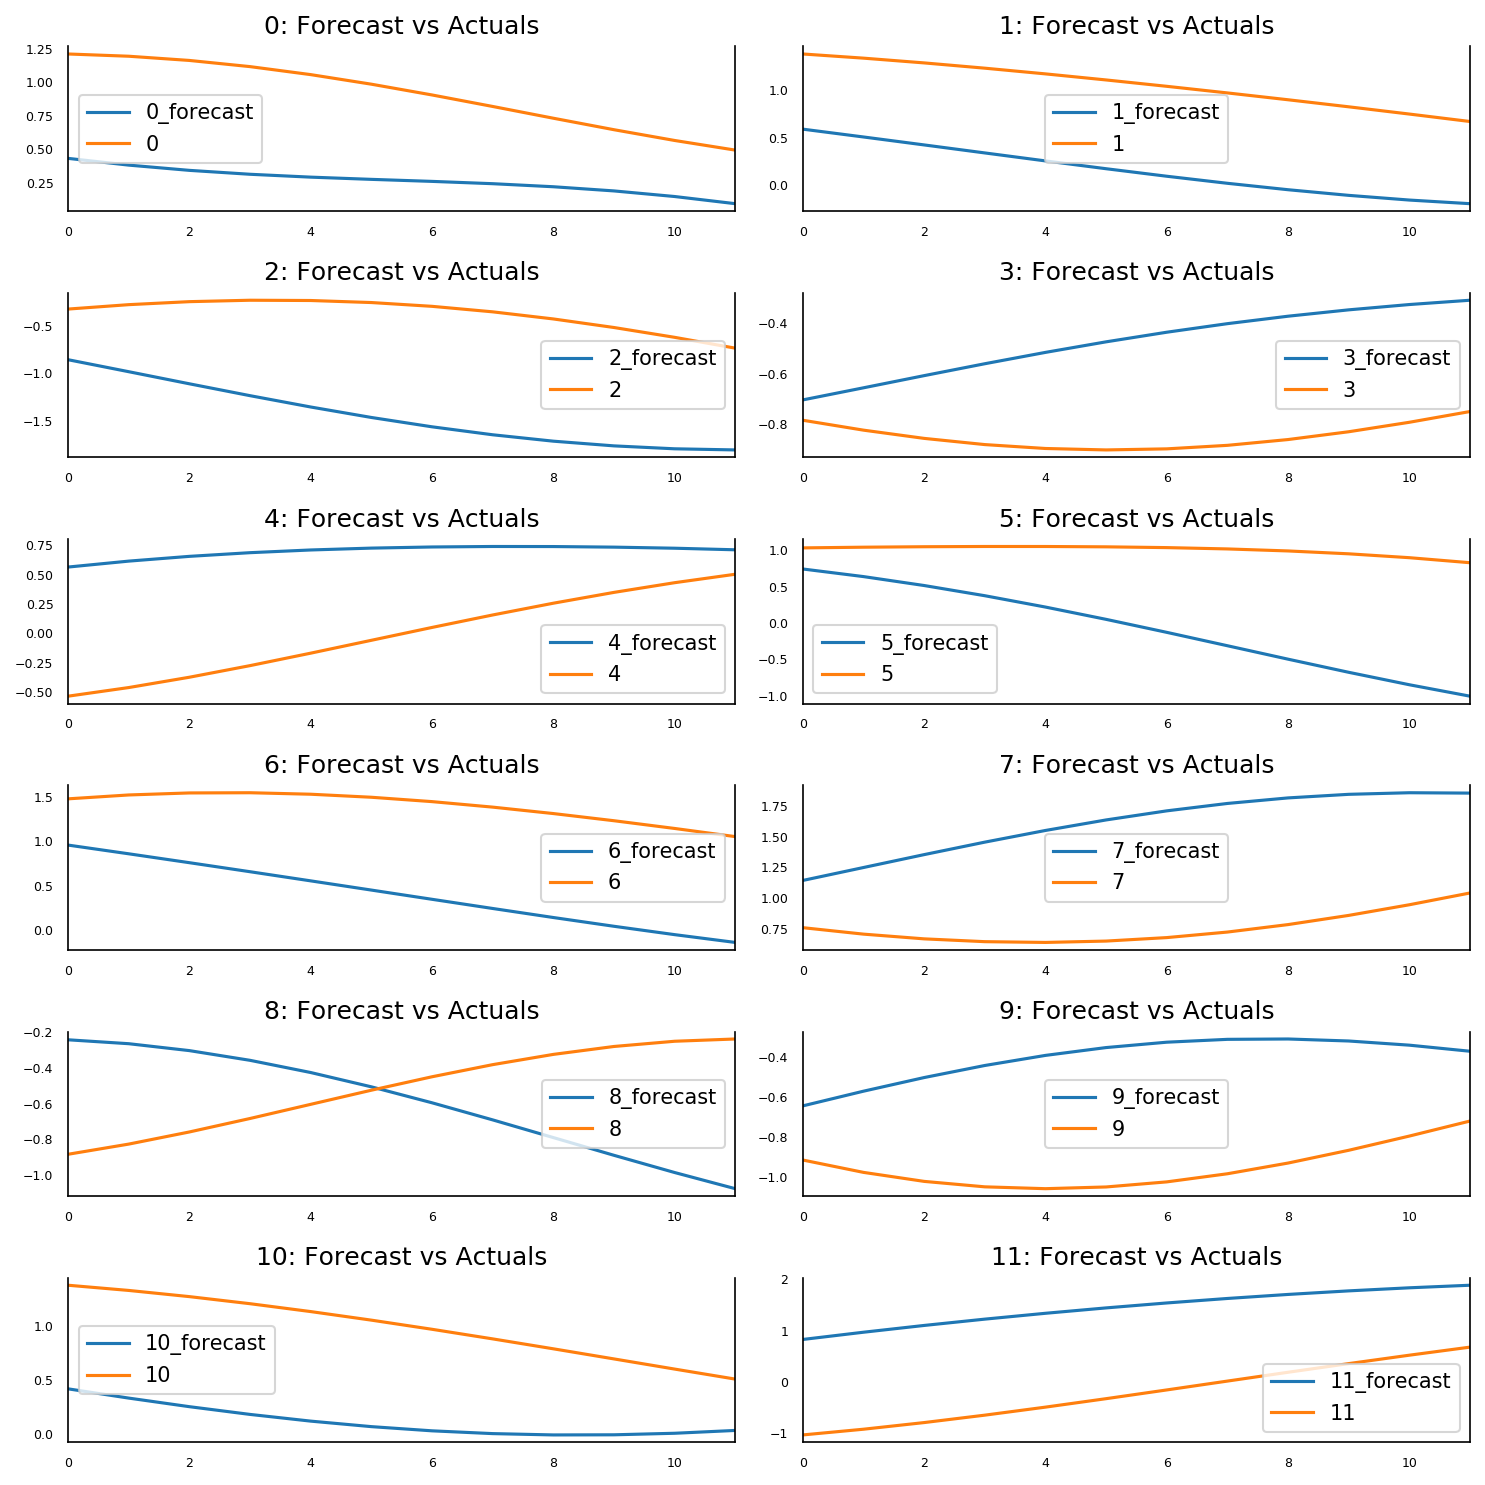

In [38]:
fig, axes = plt.subplots(nrows=int(len(file0_df.columns)/2), ncols=2, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(file0_df.columns, axes.flatten())):
    df_results[str(col)+'_forecast'].plot(legend=True, ax=ax)
    plot_df_test = df_test.set_index(df_results.index)
    plot_df_test[col][-nobs:].plot(legend=True, ax=ax);
    ax.set_title(str(col) + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [39]:
from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})

print('Forecast Accuracy of: rgnp')
mean_mae = 0
mean_mae_count = 0
for i in np.arange(0, 12):
    print(f'\nForecast Accuracy of: {i}')
    accuracy_prod = forecast_accuracy(df_results[f'{i}_forecast'].values, df_test[i])
    for k, v in accuracy_prod.items():
        print(adjust(k), ': ', round(v,4))
        if k == "mae":
            mean_mae += v
            mean_mae_count +=1
print (mean_mae / mean_mae_count)

Forecast Accuracy of: rgnp

Forecast Accuracy of: 0
mape   :  0.7139
me     :  -0.6426
mae    :  0.6426
mpe    :  -0.7139
rmse   :  0.6612
corr   :  0.9664
minmax :  0.7139

Forecast Accuracy of: 1
mape   :  0.8965
me     :  -0.8968
mae    :  0.8968
mpe    :  -0.8965
rmse   :  0.8982
corr   :  0.9864
minmax :  0.8965

Forecast Accuracy of: 2
mape   :  3.1281
me     :  -1.0581
mae    :  1.0581
mpe    :  3.1281
rmse   :  1.0837
corr   :  0.6955
minmax :  -3.1281

Forecast Accuracy of: 3
mape   :  0.4376
me     :  0.3707
mae    :  0.3707
mpe    :  -0.4376
rmse   :  0.3933
corr   :  0.1059
minmax :  -0.9033

Forecast Accuracy of: 4
mape   :  4.2123
me     :  0.7054
mae    :  0.7054
mpe    :  -0.6807
rmse   :  0.7667
corr   :  0.7945
minmax :  1.0472

Forecast Accuracy of: 5
mape   :  1.1135
me     :  -1.0756
mae    :  1.0756
mpe    :  -1.1135
rmse   :  1.1915
corr   :  0.8415
minmax :  1.1135

Forecast Accuracy of: 6
mape   :  0.7352
me     :  -0.9897
mae    :  0.9897
mpe    :  -0.7352
rms